In [1]:
from util.datagen import generator, tumor_generator
from util.model import build_seg_model

Segmentation Models: using `keras` framework.


In [2]:
import segmentation_models as sm
sm.set_framework('tf.keras')

In [3]:
import tensorflow.keras.backend as k
import gc

In [4]:
import os, glob
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import IPython
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img, array_to_img
import PIL
from PIL import ImageOps
#os.environ["CUDA_VISIBLE_DEVICES"] = '0'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (10,8)

2 Physical GPUs, 2 Logical GPUs


In [5]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [6]:
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [7]:
## config
PATIENT_PATH = glob.glob('/data/PAIP/*')
#PATIENT_PATH = glob.glob('/home/centos/jupyter/pathology/data/img/patch_overlap_global_512/*/*') # all patients
TRAIN_PATIENT_PATH = shuffle(PATIENT_PATH,random_state=311)[:int(0.60*len(PATIENT_PATH))]
VALID_PATIENT_PATH = shuffle(PATIENT_PATH,random_state=311)[int(0.60*len(PATIENT_PATH)):int(0.80*len(PATIENT_PATH))]
TEST_PATIENT_PATH = shuffle(PATIENT_PATH,random_state=311)[int(0.80*len(PATIENT_PATH)):]

TRAIN_IMG_PATH = []; TRAIN_TARGET_PATH = []
for x in TRAIN_PATIENT_PATH:
    TRAIN_TARGET_PATH.extend(glob.glob(x+'/patches/mask/*_p[2].png'))
    TRAIN_TARGET_PATH.extend(shuffle(glob.glob(x+'/patches/mask/*_p[3].png')[:30],random_state=311))
    TRAIN_TARGET_PATH.extend(glob.glob(x+'/patches/mask/*_p[4].png')[:5])
VALID_IMG_PATH = []; VALID_TARGET_PATH = []
for x in VALID_PATIENT_PATH:
    VALID_TARGET_PATH.extend(glob.glob(x+'/patches/mask/*_p[2].png'))
    VALID_TARGET_PATH.extend(shuffle(glob.glob(x+'/patches/mask/*_p[3].png')[:30],random_state=311))
    VALID_TARGET_PATH.extend(glob.glob(x+'/patches/mask/*_p[4].png')[:5])
    
TEST_IMG_PATH = []; TEST_TARGET_PATH = []
for x in TEST_PATIENT_PATH:
    TEST_TARGET_PATH.extend(glob.glob(x+'/patches/mask/*_p[2].png'))
    TEST_TARGET_PATH.extend(shuffle(glob.glob(x+'/patches/mask/*_p[3].png')[:30],random_state=311))
    TEST_TARGET_PATH.extend(glob.glob(x+'/patches/mask/*_p[4].png')[:5])
    
TRAIN_ZIP = shuffle(
    [('/'.join(x.split('/')[:-2])+'/image/'+x.split('/')[-1].replace('_p2.png','.png').replace('_p3.png','.png').replace('_p4.png','.png'),x) for x in TRAIN_TARGET_PATH],
    random_state=311
)
VALID_ZIP = shuffle(
    [('/'.join(x.split('/')[:-2])+'/image/'+x.split('/')[-1].replace('_p2.png','.png').replace('_p3.png','.png').replace('_p4.png','.png'),x) for x in VALID_TARGET_PATH]
    ,random_state=311
)
TEST_ZIP = shuffle(
    [('/'.join(x.split('/')[:-2])+'/image/'+x.split('/')[-1].replace('_p2.png','.png').replace('_p3.png','.png').replace('_p4.png','.png'),x) for x in TEST_TARGET_PATH]
    ,random_state=311
)

BATCH_SIZE = 32
INPUT_SHAPE = (512,512)
NUM_CLASSES = 1
EPOCHS = 100

In [8]:
print(len([x for x in TRAIN_ZIP if '_p2' in x[1]]))
print(len([x for x in TRAIN_ZIP if '_p3' in x[1]]))
print(len([x for x in TRAIN_ZIP if '_p4' in x[1]]))

print(len([x for x in VALID_ZIP if '_p2' in x[1]]))
print(len([x for x in VALID_ZIP if '_p3' in x[1]]))
print(len([x for x in VALID_ZIP if '_p4' in x[1]]))

print(len([x for x in TEST_ZIP if '_p2' in x[1]]))
print(len([x for x in TEST_ZIP if '_p3' in x[1]]))
print(len([x for x in TEST_ZIP if '_p4' in x[1]]))

679
847
145
327
290
50
133
281
55


In [9]:
print(len(TRAIN_ZIP),len(VALID_ZIP),len(TEST_ZIP))

1671 667 469


In [10]:
train_gen = generator(BATCH_SIZE,INPUT_SHAPE,TRAIN_ZIP,is_train=True)
valid_gen = generator(BATCH_SIZE,INPUT_SHAPE,VALID_ZIP,is_train=False)
test_gen = generator(BATCH_SIZE,INPUT_SHAPE,TEST_ZIP,is_train=False)

In [11]:
batch_x,batch_y = train_gen.__getitem__(5)

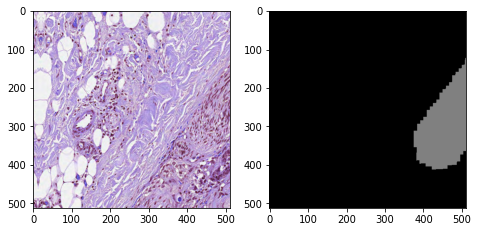

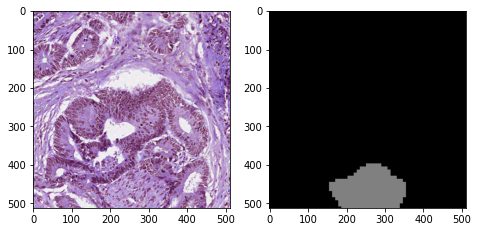

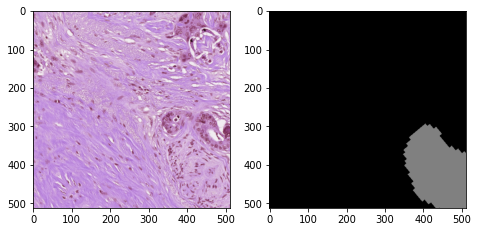

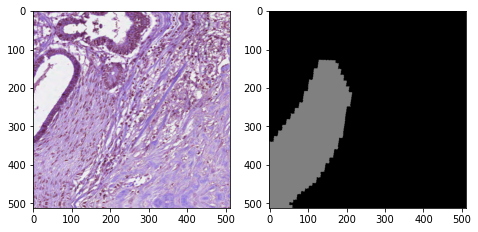

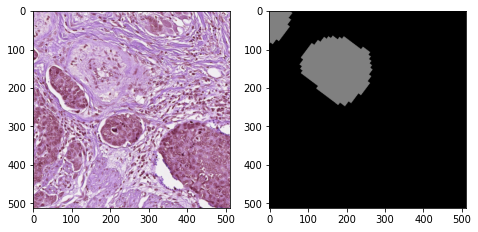

In [12]:
for idx in range(5,10):
    plt.figure(figsize = (12,6));
    d = np.unique(batch_x,return_counts=True)
    plt.subplot(1,3,1);plt.imshow((batch_x[idx]))
    plt.subplot(1,3,2);plt.imshow(np.squeeze(batch_y[idx],axis=-1),vmin=0,vmax=2)
    #plt.subplot(1,3,3);plt.bar(d[0],d[1])

---

### TRAIN BY KERAS-TUNER

from kerastuner import Hyperband, HyperParameter, HyperParameters, HyperModel

def build_model(hp):
    dice_loss = sm.losses.DiceLoss()
    focal_loss = sm.losses.BinaryFocalLoss(alpha=0.25, gamma=6.0)
    total_loss = dice_loss + focal_loss
    metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
    
    BACKBONE = hp.Choice('backbone',['inceptionresnetv2','inceptionv3'])
    model = sm.Unet(BACKBONE,input_shape=(512,512,3),classes=1,activation='sigmoid',encoder_weights='imagenet')
    '''
    if hp.Choice('optimizer',['adam','sgd'])=='adam':
        model.compile(Adam(lr=hp.Choice('learning_rate',[1e-3,1e-4,1e-5])),total_loss,metrics)
    else:
        model.compile(SGD(lr=hp.Choice('learning_rate',[1e-3,1e-4,1e-5])),total_loss,metrics)
    '''
    model.compile(optimizer = Adam(hp.Float('learning_rate',1e-4,1e-2,sampling='log')),loss=total_loss,metrics=metrics)
    return model

## CALLBACK
model_path='./data/model/seg_tumor_0718.hdf5'
mc = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
es = EarlyStopping(monitor = 'val_loss',patience = 4)
lr = ReduceLROnPlateau(
    monitor='val_loss',  # 검증 손실을 기준으로 callback이 호출됩니다
    factor=0.5,          # callback 호출시 학습률을 1/2로 줄입니다
    patience=2,         # epoch 4 동안 개선되지 않으면 callback이 호출됩니다
)
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)
callbacks_list = [mc,es,lr,ClearTrainingOutput()]

tuner = Hyperband(
    hypermodel=build_model,
    objective="val_loss",
    max_epochs=10,
    factor=3,
    hyperband_iterations=1,
    distribution_strategy=tf.distribute.MirroredStrategy(),
    directory='tumor_segmentation'
)

tuner.search(
    train_gen, 
    validation_data=valid_gen, 
    epochs=10,
    callbacks = callbacks_list
)

tuner.results_summary()

best_hp = tuner.get_best_hyperparameters()[0]


best_hp.values

best_model = tuner.hypermodel.build(best_hp)

model_path = './data/model/seg_tumor_tuner_inceptionv3.hdf5'
mc = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
es = EarlyStopping(monitor = 'val_loss',patience = 8)
lr = ReduceLROnPlateau(
    monitor='val_loss',  # 검증 손실을 기준으로 callback이 호출됩니다
    factor=0.5,          # callback 호출시 학습률을 1/2로 줄입니다
    patience=4,         # epoch 4 동안 개선되지 않으면 callback이 호출됩니다
)
callbacks_list = [mc,es,lr]

history = best_model.fit(
    train_gen,
    validation_data = valid_gen,
    callbacks = callbacks_list,
    epochs=EPOCHS,
    max_queue_size=15,
    use_multiprocessing=True,
    verbose=1
)
best_model.evaluate(test_gen)

---

### TRAIN BY FIT

In [11]:
CLASS = 'NERVE'
MODE = 'Camelyon16_Augmentv02_DiceFocalLoss_alpha_025_gamma_6'
BACKBONE = 'inceptionresnetv2'
model_path = '/data/0810.hdf5'
encoder_weight = 'imagenet'
IMAGE_SIZE = 512
CHANNEL = 3
LR = 0.002
EPOCHS = 200

preprocess_input = sm.get_preprocessing(BACKBONE)

# define network parameters
n_classes = 1
activation = 'sigmoid' 

#create model
model = sm.Unet(BACKBONE,decoder_block_type='transpose', input_shape = (IMAGE_SIZE,IMAGE_SIZE,CHANNEL),classes=n_classes, activation=activation,encoder_weights=encoder_weight)

In [12]:
from tensorflow.keras.callbacks import Callback
# define optomizer
optim = Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()

# default focal_loss (alpha=0.25, gamma=2.0)
focal_loss = sm.losses.BinaryFocalLoss(alpha=0.25, gamma=6.0)
total_loss = dice_loss + focal_loss


# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
#metrics = [my_metric]
class ClearMemory(Callback):
    def on_epoch_end(self,epoch,logs=None):
        gc.collect()
        k.clear_session()
        
mc = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
es = EarlyStopping(monitor = 'val_loss',patience = 10)
lr = ReduceLROnPlateau(
    monitor='val_loss',  # 검증 손실을 기준으로 callback이 호출됩니다
    factor=0.5,          # callback 호출시 학습률을 1/2로 줄입니다
    patience=5,         # epoch 4 동안 개선되지 않으면 callback이 호출됩니다
)
callbacks_list = [mc,es,lr,ClearMemory()]
#mc = ModelCheckpoint(history_files); lr = ReduceLROnPlateau()
#callback_list = [mc,lr]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [17]:
## MULTIGPU
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
with strategy.scope():
    model = sm.Unet(BACKBONE, input_shape = (IMAGE_SIZE,IMAGE_SIZE,CHANNEL),classes=n_classes, activation=activation,encoder_weights=encoder_weight)
    model.compile(optim, total_loss, metrics)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:

In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 256, 256, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 256, 256, 32) 96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 256, 256, 32) 0           batch_normalization_203[0][0]    
____________________________________________________________________________________________

Trainable params: 61,999,025
Non-trainable params: 62,528
__________________________________________________________________________________________________


In [19]:
history = model.fit(train_gen, 
                    epochs = EPOCHS,
                    validation_data=valid_gen,
                    callbacks=callbacks_list,
                    max_queue_size=20,
                    workers=10,
                    #use_multiprocessing=True,
                    verbose=1
                   )

Epoch 1/200
INFO:tensorflow:batch_all_reduce: 520 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 520 all-reduces with algorithm = nccl, num_packs = 1
52/52 [==============================] - 237s 2s/step - loss: 0.6337 - iou_score: 0.3526 - f1-score: 0.4987 - val_loss: 1.4065 - val_iou_score: 1.3568e-04 - val_f1-score: 2.7131e-04

Epoch 00001: val_loss improved from inf to 1.40655, saving model to /data/0810.hdf5
Epoch 2/200
INFO:tensorflow:batch_all_reduce: 520 all-reduces with algorithm = nccl, num_packs = 1
52/52 [==============================] - 167s 2s/step - loss: 0.4329 - iou_score: 0.4775 - f1-score: 0.6380 - val_loss: 1.6398 - val_iou_score: 0.0259 - val_f1-score: 0.0489

Epoch 00002: val_loss did not improve from 1.40655
Epoch 3/200
52/52 [==============================] - 88s 1s/step - loss: 0.3962 - iou_score: 0.5157 - f1-score: 0.6722 - val_loss: 1.8982 - val_iou_score: 0.0229 - val_f1-score: 0.0445

Epoch 00003: val_loss did not improv

IndexError: pop from empty list

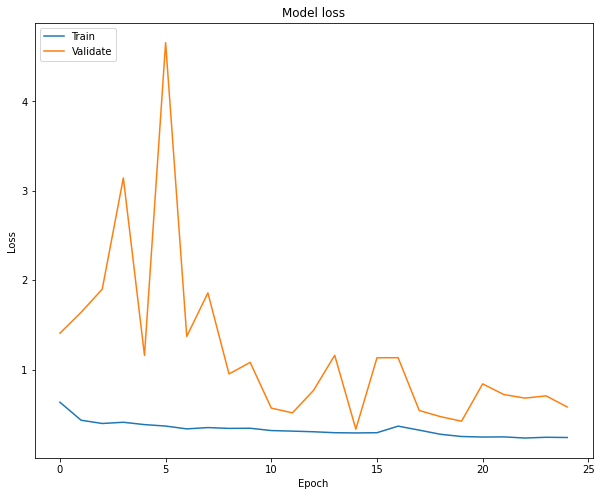

In [22]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

In [23]:
e_val = model.evaluate(test_gen)
print(f'IOU Score : {e_val[1]:.2f} F1-Score : {e_val[2]:.2f}')

14/14 [==============================] - 8s 561ms/step - loss: 0.6157 - iou_score: 0.3094 - f1-score: 0.4441
IOU Score : 0.31 F1-Score : 0.44


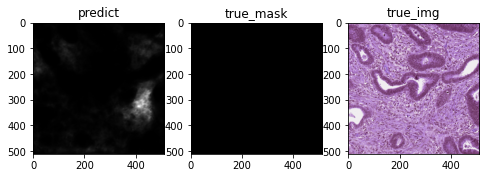

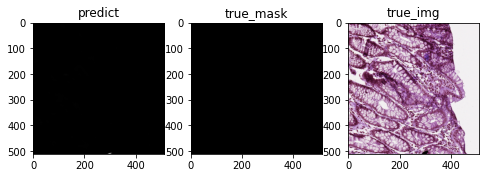

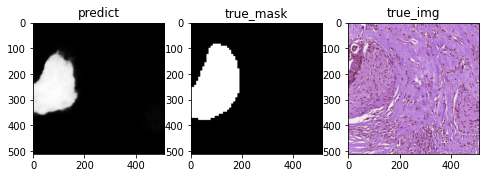

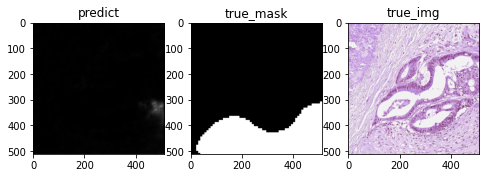

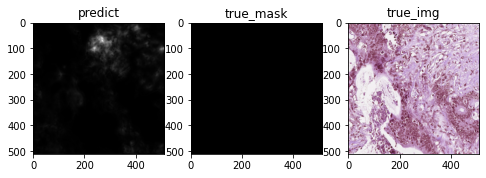

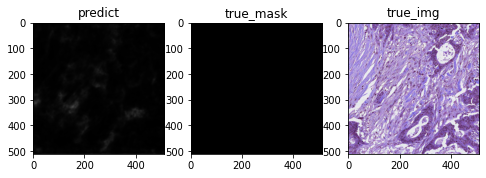

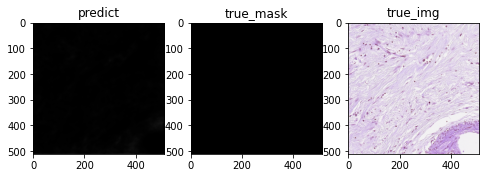

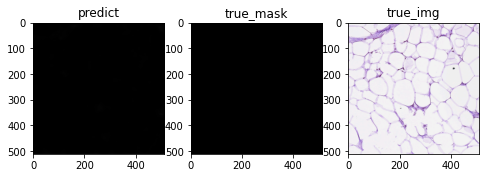

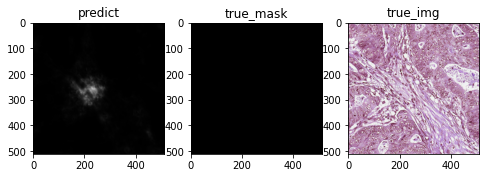

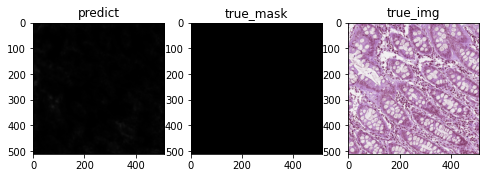

In [24]:
batch_x,batch_y=  test_gen.__getitem__(0)
for i in range(10,20):

    img,msk = batch_x[i],batch_y[i]
    img = np.expand_dims(img,axis=0)
    pr_msk = model.predict(img)
    pr_msk = np.squeeze(pr_msk)
    plt.figure(figsize = (8,6))
    plt.subplot(1,3,1); plt.title('predict'); plt.imshow(pr_msk)
    plt.subplot(1,3,2); plt.title('true_mask'); plt.imshow(np.squeeze(batch_y[i]))
    plt.subplot(1,3,3); plt.title('true_img'); plt.imshow(np.squeeze((255*img).astype(np.uint8)))

#pr_msk = np.expand_dims(pr_msk,axis=-1)


---

In [13]:
def SepConv_BN(x, filters, prefix, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):
    """ SepConv with BN between depthwise & pointwise. Optionally add activation after BN
        Implements right "same" padding for even kernel sizes
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & poinwise convs
            epsilon: epsilon to use in BN layer
    """

    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'

    if not depth_activation:
        x = Activation(tf.nn.relu)(x)
    x = DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),
                        kernel_initializer = 'he_normal',
                        padding=depth_padding, use_bias=False, name=prefix + '_depthwise')(x)
    x = BatchNormalization(name=prefix + '_depthwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation(tf.nn.relu)(x)
    x = Conv2D(filters, (1, 1), padding='same',kernel_initializer = 'he_normal',
               use_bias=False, name=prefix + '_pointwise')(x)
    x = BatchNormalization(name=prefix + '_pointwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation(tf.nn.relu)(x)

    return x


def _conv2d_same(x, filters, prefix, stride=1, kernel_size=3, rate=1):
    """Implements right 'same' padding for even kernel sizes
        Without this there is a 1 pixel drift when stride = 2
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
    """
    if stride == 1:
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='same', use_bias=False,
                      dilation_rate=(rate, rate),
                      kernel_initializer = 'he_normal',
                      name=prefix)(x)
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      kernel_initializer = 'he_normal',
                      padding='valid', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)


def _xception_block(inputs, depth_list, prefix, skip_connection_type, stride,
                    rate=1, depth_activation=False, return_skip=False):
    """ Basic building block of modified Xception network
        Args:
            inputs: input tensor
            depth_list: number of filters in each SepConv layer. len(depth_list) == 3
            prefix: prefix before name
            skip_connection_type: one of {'conv','sum','none'}
            stride: stride at last depthwise conv
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & pointwise convs
            return_skip: flag to return additional tensor after 2 SepConvs for decoder
            """
    residual = inputs
    for i in range(3):
        residual = SepConv_BN(residual,
                              depth_list[i],
                              prefix + '_separable_conv{}'.format(i + 1),
                              stride=stride if i == 2 else 1,
                              rate=rate,
                              depth_activation=depth_activation)
        if i == 1:
            skip = residual
    if skip_connection_type == 'conv':
        shortcut = _conv2d_same(inputs, depth_list[-1], prefix + '_shortcut',
                                kernel_size=1,
                                stride=stride)
        shortcut = BatchNormalization(name=prefix + '_shortcut_BN')(shortcut)
        outputs = Add()([residual, shortcut])
    elif skip_connection_type == 'sum':
        outputs = Add()([residual, inputs])
    elif skip_connection_type == 'none':
        outputs = residual
    if return_skip:
        return outputs, skip
    else:
        return outputs


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id, skip_connection, rate=1):
    in_channels = inputs.shape[-1]  # inputs._keras_shape[-1]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'expanded_conv_{}_'.format(block_id)
    if block_id:
        # Expand

        x = Conv2D(expansion * in_channels, kernel_size=1, padding='same',
                   use_bias=False, activation=None,
                   kernel_initializer = 'he_normal',
                   name=prefix + 'expand')(x)
        x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                               name=prefix + 'expand_BN')(x)
        x = Activation(tf.nn.relu6, name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'
    # Depthwise
    x = DepthwiseConv2D(kernel_size=3, strides=stride, activation=None,kernel_initializer = 'he_normal',
                        use_bias=False, padding='same', dilation_rate=(rate, rate),
                        name=prefix + 'depthwise')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'depthwise_BN')(x)

    x = Activation(tf.nn.relu6, name=prefix + 'depthwise_relu')(x)

    # Project
    x = Conv2D(pointwise_filters,kernel_initializer = 'he_normal',
               kernel_size=1, padding='same', use_bias=False, activation=None,
               name=prefix + 'project')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'project_BN')(x)

    if skip_connection:
        return Add(name=prefix + 'add')([inputs, x])

    # if in_channels == pointwise_filters and stride == 1:
    #    return Add(name='res_connect_' + str(block_id))([inputs, x])

    return x


def Deeplabv3(weights='pascal_voc', input_tensor=None, input_shape=(512, 512, 3), classes=21, backbone='mobilenetv2',
              OS=16, alpha=1., activation=None):
    """ Instantiates the Deeplabv3+ architecture
    Optionally loads weights pre-trained
    on PASCAL VOC or Cityscapes. This model is available for TensorFlow only.
    # Arguments
        weights: one of 'pascal_voc' (pre-trained on pascal voc),
            'cityscapes' (pre-trained on cityscape) or None (random initialization)
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: shape of input image. format HxWxC
            PASCAL VOC model was trained on (512,512,3) images. None is allowed as shape/width
        classes: number of desired classes. PASCAL VOC has 21 classes, Cityscapes has 19 classes.
            If number of classes not aligned with the weights used, last layer is initialized randomly
        backbone: backbone to use. one of {'xception','mobilenetv2'}
        activation: optional activation to add to the top of the network.
            One of 'softmax', 'sigmoid' or None
        OS: determines input_shape/feature_extractor_output ratio. One of {8,16}.
            Used only for xception backbone.
        alpha: controls the width of the MobileNetV2 network. This is known as the
            width multiplier in the MobileNetV2 paper.
                - If `alpha` < 1.0, proportionally decreases the number
                    of filters in each layer.
                - If `alpha` > 1.0, proportionally increases the number
                    of filters in each layer.
                - If `alpha` = 1, default number of filters from the paper
                    are used at each layer.
            Used only for mobilenetv2 backbone. Pretrained is only available for alpha=1.
    # Returns
        A Keras model instance.
    # Raises
        RuntimeError: If attempting to run this model with a
            backend that does not support separable convolutions.
        ValueError: in case of invalid argument for `weights` or `backbone`
    """

    if not (weights in {'pascal_voc', 'cityscapes', None}):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `pascal_voc`, or `cityscapes` '
                         '(pre-trained on PASCAL VOC)')

    if not (backbone in {'xception', 'mobilenetv2'}):
        raise ValueError('The `backbone` argument should be either '
                         '`xception`  or `mobilenetv2` ')

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        img_input = input_tensor

    if backbone == 'xception':
        if OS == 8:
            entry_block3_stride = 1
            middle_block_rate = 2  # ! Not mentioned in paper, but required
            exit_block_rates = (2, 4)
            atrous_rates = (12, 24, 36)
        else:
            entry_block3_stride = 2
            middle_block_rate = 1
            exit_block_rates = (1, 2)
            atrous_rates = (6, 12, 18)

        x = Conv2D(32, (3, 3), strides=(2, 2),
                   name='entry_flow_conv1_1', use_bias=False, padding='same')(img_input)
        x = BatchNormalization(name='entry_flow_conv1_1_BN')(x)
        x = Activation(tf.nn.relu)(x)

        x = _conv2d_same(x, 64, 'entry_flow_conv1_2', kernel_size=3, stride=1)
        x = BatchNormalization(name='entry_flow_conv1_2_BN')(x)
        x = Activation(tf.nn.relu)(x)

        x = _xception_block(x, [128, 128, 128], 'entry_flow_block1',
                            skip_connection_type='conv', stride=2,
                            depth_activation=False)
        x, skip1 = _xception_block(x, [256, 256, 256], 'entry_flow_block2',
                                   skip_connection_type='conv', stride=2,
                                   depth_activation=False, return_skip=True)

        x = _xception_block(x, [728, 728, 728], 'entry_flow_block3',
                            skip_connection_type='conv', stride=entry_block3_stride,
                            depth_activation=False)
        for i in range(16):
            x = _xception_block(x, [728, 728, 728], 'middle_flow_unit_{}'.format(i + 1),
                                skip_connection_type='sum', stride=1, rate=middle_block_rate,
                                depth_activation=False)

        x = _xception_block(x, [728, 1024, 1024], 'exit_flow_block1',
                            skip_connection_type='conv', stride=1, rate=exit_block_rates[0],
                            depth_activation=False)
        x = _xception_block(x, [1536, 1536, 2048], 'exit_flow_block2',
                            skip_connection_type='none', stride=1, rate=exit_block_rates[1],
                            depth_activation=True)

    else:
        OS = 8
        first_block_filters = _make_divisible(32 * alpha, 8)
        x = Conv2D(first_block_filters,
                   kernel_size=3,
                   strides=(2, 2), padding='same', use_bias=False,
                   name='Conv' if input_shape[2] == 3 else 'Conv_')(img_input)
        x = BatchNormalization(
            epsilon=1e-3, momentum=0.999, name='Conv_BN')(x)
        x = Activation(tf.nn.relu6, name='Conv_Relu6')(x)

        x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1,
                                expansion=1, block_id=0, skip_connection=False)

        x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2,
                                expansion=6, block_id=1, skip_connection=False)
        x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1,
                                expansion=6, block_id=2, skip_connection=True)

        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2,
                                expansion=6, block_id=3, skip_connection=False)
        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                                expansion=6, block_id=4, skip_connection=True)
        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                                expansion=6, block_id=5, skip_connection=True)

        # stride in block 6 changed from 2 -> 1, so we need to use rate = 2
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,  # 1!
                                expansion=6, block_id=6, skip_connection=False)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=7, skip_connection=True)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=8, skip_connection=True)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=9, skip_connection=True)

        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=10, skip_connection=False)
        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=11, skip_connection=True)
        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=12, skip_connection=True)

        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=2,  # 1!
                                expansion=6, block_id=13, skip_connection=False)
        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=14, skip_connection=True)
        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=15, skip_connection=True)

        x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=16, skip_connection=False)

    # end of feature extractor

    # branching for Atrous Spatial Pyramid Pooling

    # Image Feature branch
    shape_before = tf.shape(x)
    b4 = GlobalAveragePooling2D()(x)
    b4_shape = tf.keras.backend.int_shape(b4)
    # from (b_size, channels)->(b_size, 1, 1, channels)
    b4 = Reshape((1, 1, b4_shape[1]))(b4)
    b4 = Conv2D(256, (1, 1), padding='same',
                use_bias=False, name='image_pooling')(b4)
    b4 = BatchNormalization(name='image_pooling_BN', epsilon=1e-5)(b4)
    b4 = Activation(tf.nn.relu)(b4)
    # upsample. have to use compat because of the option align_corners
    size_before = tf.keras.backend.int_shape(x)
    b4 = tf.keras.layers.experimental.preprocessing.Resizing(
            *size_before[1:3], interpolation="bilinear"
        )(b4)
    # simple 1x1
    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp0')(x)
    b0 = BatchNormalization(name='aspp0_BN', epsilon=1e-5)(b0)
    b0 = Activation(tf.nn.relu, name='aspp0_activation')(b0)

    # there are only 2 branches in mobilenetV2. not sure why
    if backbone == 'xception':
        # rate = 6 (12)
        b1 = SepConv_BN(x, 256, 'aspp1',
                        rate=atrous_rates[0], depth_activation=True, epsilon=1e-5)
        # rate = 12 (24)
        b2 = SepConv_BN(x, 256, 'aspp2',
                        rate=atrous_rates[1], depth_activation=True, epsilon=1e-5)
        # rate = 18 (36)
        b3 = SepConv_BN(x, 256, 'aspp3',
                        rate=atrous_rates[2], depth_activation=True, epsilon=1e-5)

        # concatenate ASPP branches & project
        x = Concatenate()([b4, b0, b1, b2, b3])
    else:
        x = Concatenate()([b4, b0])

    x = Conv2D(256, (1, 1), padding='same',
               use_bias=False, name='concat_projection')(x)
    x = BatchNormalization(name='concat_projection_BN', epsilon=1e-5)(x)
    x = Activation(tf.nn.relu)(x)
    x = Dropout(0.1)(x)
    # DeepLab v.3+ decoder

    if backbone == 'xception':
        # Feature projection
        # x4 (x2) block
        skip_size = tf.keras.backend.int_shape(skip1)
        x = tf.keras.layers.experimental.preprocessing.Resizing(
                *skip_size[1:3], interpolation="bilinear"
            )(x)
        dec_skip1 = Conv2D(48, (1, 1), padding='same',
                           use_bias=False, name='feature_projection0')(skip1)
        dec_skip1 = BatchNormalization(
            name='feature_projection0_BN', epsilon=1e-5)(dec_skip1)
        dec_skip1 = Activation(tf.nn.relu)(dec_skip1)
        x = Concatenate()([x, dec_skip1])
        x = SepConv_BN(x, 256, 'decoder_conv0',
                       depth_activation=True, epsilon=1e-5)
        x = SepConv_BN(x, 256, 'decoder_conv1',
                       depth_activation=True, epsilon=1e-5)

    # you can use it with arbitary number of classes
    if (weights == 'pascal_voc' and classes == 21) or (weights == 'cityscapes' and classes == 19):
        last_layer_name = 'logits_semantic'
    else:
        last_layer_name = 'custom_logits_semantic'

    x = Conv2D(classes, (1, 1), padding='same', name=last_layer_name)(x)
    size_before3 = tf.keras.backend.int_shape(img_input)
    x = tf.keras.layers.experimental.preprocessing.Resizing(
            *size_before3[1:3], interpolation="bilinear"
        )(x)
    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    if activation in {'softmax', 'sigmoid'}:
        x = tf.keras.layers.Activation(activation)(x)

    model = Model(inputs, x, name='deeplabv3plus')

    # load weights

    if weights == 'pascal_voc':
        if backbone == 'xception':
            weights_path = get_file('deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH_X,
                                    cache_subdir='models')
        else:
            weights_path = get_file('deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH_MOBILE,
                                    cache_subdir='models')
        model.load_weights(weights_path, by_name=True)
    elif weights == 'cityscapes':
        if backbone == 'xception':
            weights_path = get_file('deeplabv3_xception_tf_dim_ordering_tf_kernels_cityscapes.h5',
                                    WEIGHTS_PATH_X_CS,
                                    cache_subdir='models')
        else:
            weights_path = get_file('deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels_cityscapes.h5',
                                    WEIGHTS_PATH_MOBILE_CS,
                                    cache_subdir='models')
        model.load_weights(weights_path, by_name=True)
    else:
        pass
    return model

In [14]:
WEIGHTS_PATH_X = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_MOBILE = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_X_CS = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.2/deeplabv3_xception_tf_dim_ordering_tf_kernels_cityscapes.h5"
WEIGHTS_PATH_MOBILE_CS = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.2/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels_cityscapes.h5"

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.python.keras.utils.data_utils import get_file
mdl = Deeplabv3(classes = 1,activation='sigmoid',)

In [16]:
IMAGE_SIZE = 512
CHANNEL = 3
LR = 0.001
EPOCHS = 200
MODEL_PATH='/data/0811_deeplabv3_2.hdf5'

In [17]:
from tensorflow.keras.callbacks import Callback
# define optomizer
optim = Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()

# default focal_loss (alpha=0.25, gamma=2.0)
focal_loss = sm.losses.BinaryFocalLoss(alpha=0.25, gamma=6.0)
total_loss = dice_loss + focal_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
#metrics = [my_metric]
class ClearMemory(Callback):
    def on_epoch_end(self,epoch,logs=None):
        gc.collect()
        k.clear_session()
        
mc = ModelCheckpoint(filepath=MODEL_PATH, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
es = EarlyStopping(monitor = 'val_loss',patience = 10)
lr = ReduceLROnPlateau(
    monitor='val_loss',  # 검증 손실을 기준으로 callback이 호출됩니다
    factor=0.5,          # callback 호출시 학습률을 1/2로 줄입니다
    patience=4,         # epoch 4 동안 개선되지 않으면 callback이 호출됩니다
)
callbacks_list = [mc,es,lr,ClearMemory()]
#mc = ModelCheckpoint(history_files); lr = ReduceLROnPlateau()
#callback_list = [mc,lr]

In [18]:
from tensorflow.python.keras.utils.data_utils import get_file

In [19]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
with strategy.scope():
    model = Deeplabv3(input_shape = (IMAGE_SIZE,IMAGE_SIZE,CHANNEL),classes=1,activation='sigmoid',
                      backbone='xception')
    model.compile(optim, total_loss, metrics)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:

In [20]:
model.fit(train_gen, 
          epochs = EPOCHS,
          validation_data=valid_gen,
          callbacks=callbacks_list,
          max_queue_size=20,
          workers=10,
          #use_multiprocessing=True,
          verbose=1
         )

Epoch 1/200
INFO:tensorflow:batch_all_reduce: 440 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 440 all-reduces with algorithm = nccl, num_packs = 1
52/52 [==============================] - 181s 2s/step - loss: 0.5635 - iou_score: 0.4001 - f1-score: 0.5495 - val_loss: 1.5021 - val_iou_score: 0.0078 - val_f1-score: 0.0154

Epoch 00001: val_loss improved from inf to 1.50211, saving model to /data/0811_deeplabv3_2.hdf5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/200
INFO:tensorflow:batch_all_reduce: 440 all-reduces with algorithm = nccl, num_packs = 1
52/52 [==============================] - 142s 2s/step - loss: 0.3833 - iou_score: 0.5237 - f1-score: 0.6797 - val_loss: 1.4521 - val_iou_score: 0.1066 - val_f1-score: 0.1880

Epoch 00002: val_loss improved from 1.50211 to 1.45207, saving model to /data/0811_deeplabv3_2.hdf5
Epoch 3/200
52/52 [==============================] - 90s 1s/step - loss: 0.3592 - iou_score: 0.5498 - f1-score: 0.7012 - val_loss: 6.8224 - val_iou_score: 0.1436 - val_f1-score: 0.2482

Epoch 00003: val_loss did not improve from 1.45207
Epoch 4/200
52/52 [==============================] - 86s 1s/step - loss: 0.3411 - iou_score: 0.5657 - f1-score: 0.7165 - val_loss: 1.0247 - val_iou_score: 0.1898 - val_f1-score: 0.3146

Epoch 00004: val_loss improved from 1.45207 to 1.02472, saving model to /data/0811_deeplabv3_2.hdf5
Epoch 5/200
52/52 [==============================] - 92s 1s/step - loss: 0.3034 - iou_score: 0.6033 - f

IndexError: pop from empty list

In [21]:
model.summary()

Model: "deeplabv3plus"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
entry_flow_conv1_1 (Conv2D)     (None, 256, 256, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
entry_flow_conv1_1_BN (BatchNor (None, 256, 256, 32) 128         entry_flow_conv1_1[0][0]         
__________________________________________________________________________________________________
activation_206 (Activation)     (None, 256, 256, 32) 0           entry_flow_conv1_1_BN[0][0]      
______________________________________________________________________________________

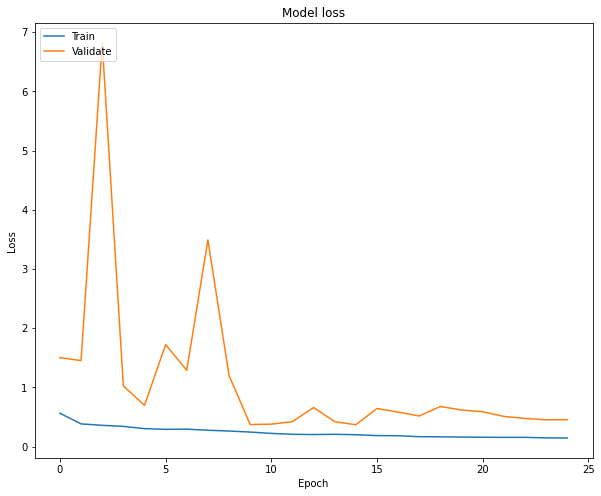

In [22]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

In [23]:
e_val = model.evaluate(test_gen)
print(f'IOU Score : {e_val[1]:.2f} F1-Score : {e_val[2]:.2f}')

14/14 [==============================] - 8s 552ms/step - loss: 0.4866 - iou_score: 0.4057 - f1-score: 0.5590
IOU Score : 0.41 F1-Score : 0.56


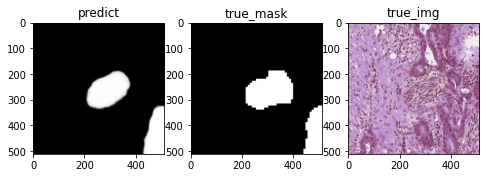

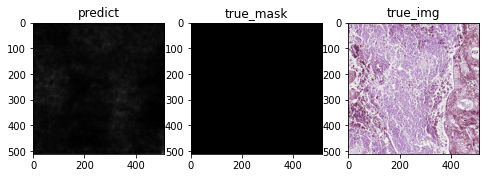

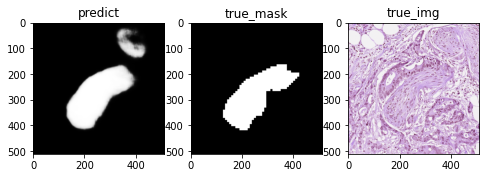

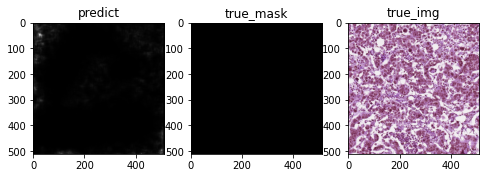

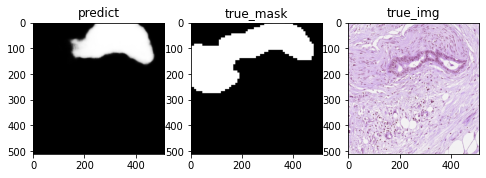

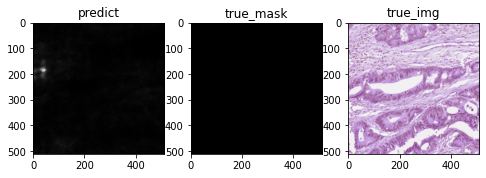

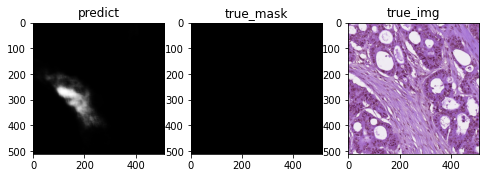

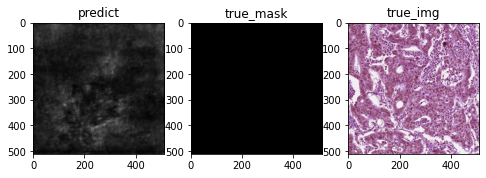

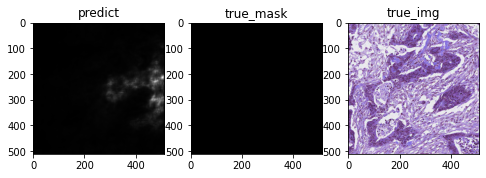

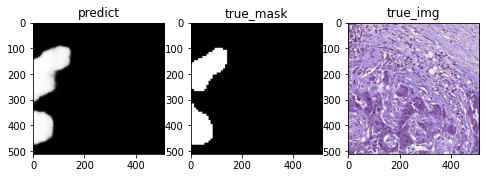

In [24]:
batch_x,batch_y=  test_gen.__getitem__(3)
for i in range(10,20):

    img,msk = batch_x[i],batch_y[i]
    img = np.expand_dims(img,axis=0)
    pr_msk = model.predict(img)
    pr_msk = np.squeeze(pr_msk)
    plt.figure(figsize = (8,6))
    plt.subplot(1,3,1); plt.title('predict'); plt.imshow(pr_msk)
    plt.subplot(1,3,2); plt.title('true_mask'); plt.imshow(np.squeeze(batch_y[i]))
    plt.subplot(1,3,3); plt.title('true_img'); plt.imshow(np.squeeze((255*img).astype(np.uint8)))

#pr_msk = np.expand_dims(pr_msk,axis=-1)
